In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


In [3]:
df = pd.read_csv('data1.csv')
df.head()

,ID,InstallYear,Diameter,Length,Material,ExpBreak (Target),Age2018
0,37260,1996,2.0,574.17,14,1,22
1,13986,1986,4.0,1123.21,4,1,32
2,13986,1986,4.0,1123.21,4,1,32
3,4582,1980,2.0,107.85,12,1,38
4,31809,1980,2.0,132.37,12,1,38


In [6]:
# keep ID separately for later checks, drop BreakYear and BreakAge from the main dataframe
ids = df['ID'].copy()

# df_clean = df.drop(columns=['BreakYear', 'BreakAge'])

# prepare features X (exclude ID and the target) and target y
X = df.drop(columns=['ID', 'ExpBreak (Target)'])
y = df['ExpBreak (Target)']

# quick sanity checks
print("Remaining columns:", df.columns.tolist())
print("X shape:", X.shape, "y shape:", y.shape)

Remaining columns: ['ID', 'InstallYear', 'Diameter', 'Length', 'Material', 'ExpBreak (Target)', 'Age2018']
X shape: (42505, 5) y shape: (42505,)


In [7]:
df1 =df.copy()
df1.isnull().sum()

ID                   0
InstallYear          0
Diameter             0
Length               0
Material             0
ExpBreak (Target)    0
Age2018              0
dtype: int64

In [9]:
df1 = df.drop(columns=['Failure_ID'])

KeyError: "['Failure_ID'] not found in axis"

In [ ]:
df1.dtypes

ID                     int64
InstallYear            int64
Diameter             float64
Length               float64
Material               int64
ExpBreak (Target)      int64
Age2018                int64
dtype: object

In [ ]:
df1.shape

(42505, 9)

Class counts:
 ExpBreak (Target)
0    40341
1     2164
Name: count, dtype: int64

Class percentages:
 ExpBreak (Target)
0    94.91
1     5.09
Name: proportion, dtype: float64


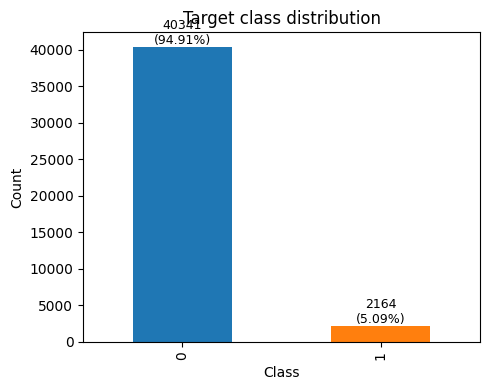

In [10]:
# check class distribution of the target 'y'
counts = y.value_counts()
percent = y.value_counts(normalize=True) * 100

print("Class counts:\n", counts)
print("\nClass percentages:\n", percent.round(2))

# quick bar plot for visual check
ax = counts.plot(kind='bar', figsize=(5,4), color=['C0','C1'])
ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('Target class distribution')

# annotate bars with percentage
total = len(y)
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}\n({height/total:.2%})',
                (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [ ]:
# df1 = df1.drop(columns=['BreakYear', 'BreakAge'])

In [ ]:
# # prepare features X (exclude ID and the target) and target y
# X = df1.drop(columns=['ID', 'ExpBreak (Target)'])
# y = df1['ExpBreak (Target)']

# # quick sanity checks
# print("Remaining columns:", df1.columns.tolist())
# print("X shape:", X.shape, "y shape:", y.shape)

Remaining columns: ['ID', 'InstallYear', 'Diameter', 'Length', 'Material', 'ExpBreak (Target)', 'Age2018']
X shape: (42505, 5) y shape: (42505,)


In [11]:
X.isnull().sum()

InstallYear    0
Diameter       0
Length         0
Material       0
Age2018        0
dtype: int64

In [12]:
df1.shape

(42505, 7)

In [13]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check new class distribution
print("After SMOTE:", np.bincount(y_resampled))

After SMOTE: [40341 40341]


Top 20% Riskiest Pipes:
          ID  Failure_Probability
7305   30154             1.000000
706     2898             1.000000
31460  40083             1.000000
369    17663             1.000000
21472  16895             0.999999
...      ...                  ...
38432  11161             0.458021
41202  31121             0.458021
40617  29344             0.458021
40766  25443             0.458021
1169   24602             0.458020

[8501 rows x 2 columns]


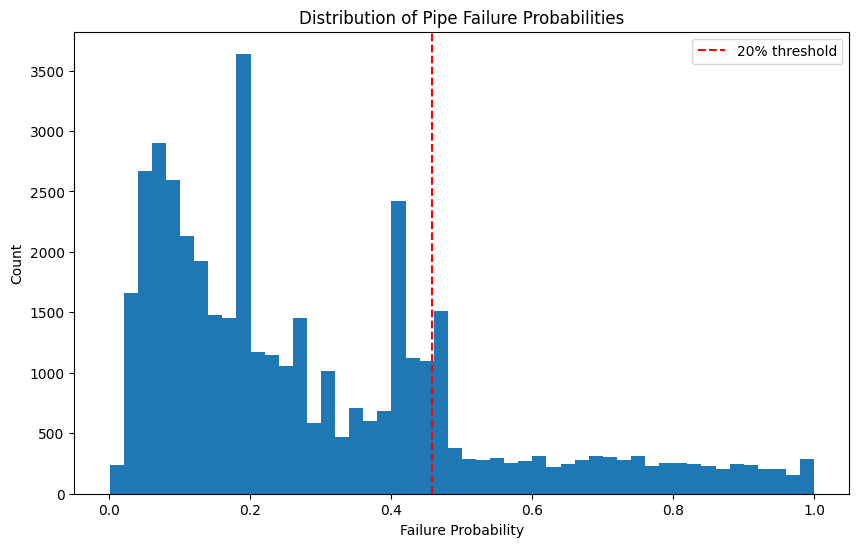


Summary of Top 20% Riskiest Pipes:
Number of pipes: 8501
Minimum probability threshold: 0.458
Average failure probability: 0.671
Maximum failure probability: 1.000


In [14]:
# Step 1: Train a probability model (using LogisticRegression since it's a binary classification)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Split the resampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify=y_resampled)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_scaled = scaler.transform(X)  # Scale original data for final prediction

# Train the model
model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)

# Get probability predictions for all pipes
failure_probs = model.predict_proba(X_scaled)[:, 1]  # Probability of class 1 (failure)

# Create a DataFrame with IDs and failure probabilities
risk_assessment = pd.DataFrame({
    'ID': ids,  # Original pipe IDs
    'Failure_Probability': failure_probs
})

# Sort by failure probability in descending order
risk_assessment = risk_assessment.sort_values('Failure_Probability', ascending=False)

# Get top 20% riskiest pipes
n_risky = int(len(risk_assessment) * 0.2)
riskiest_pipes = risk_assessment.head(n_risky)

print("Top 20% Riskiest Pipes:")
print(riskiest_pipes)

# Visualize the distribution of failure probabilities
plt.figure(figsize=(10, 6))
plt.hist(risk_assessment['Failure_Probability'], bins=50)
plt.axvline(risk_assessment.iloc[n_risky-1]['Failure_Probability'], 
            color='r', linestyle='--', 
            label='20% threshold')
plt.xlabel('Failure Probability')
plt.ylabel('Count')
plt.title('Distribution of Pipe Failure Probabilities')
plt.legend()
plt.show()

# Summary statistics for the riskiest pipes
print("\nSummary of Top 20% Riskiest Pipes:")
print(f"Number of pipes: {len(riskiest_pipes)}")
print(f"Minimum probability threshold: {riskiest_pipes['Failure_Probability'].min():.3f}")
print(f"Average failure probability: {riskiest_pipes['Failure_Probability'].mean():.3f}")
print(f"Maximum failure probability: {riskiest_pipes['Failure_Probability'].max():.3f}")

# Save results to CSV
riskiest_pipes.to_csv('riskiest_pipes.csv', index=False)

In [15]:
df2 = pd.read_csv('data2.csv')

In [ ]:
# !pip install pymc arviz --quiet


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires joblib~=1.1.0, but you have joblib 1.4.2 which is incompatible.
pandas-profiling 3.2.0 requires visions[type_image_path]==0.7.4, but you have visions 0.8.1 which is incompatible.
tensorflow-intel 2.17.0 requires numpy<2.0.0,>=1.26.0; python_version >= "3.12", but you have numpy 2.2.6 which is incompatible.
ydata-profiling 4.15.0 requires numpy<2.2,>=1.16.0, but you have numpy 2.2.6 which is incompatible.
numba 0.59.1 requires numpy<1.27,>=1.22, but you have numpy 2.2.6 which is incompatible.
pywavelets 1.5.0 requires numpy<2.0,>=1.22.4, but you have numpy

In [30]:
# # ------------------------------
# # Step 1: Bayesian Logistic Regression for Pipe Failure Probability
# # ------------------------------

# import pymc as pm
# import arviz as az
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler

# # -----------------------------------------
# # STEP 0: Split the resampled data (same as before)
# # -----------------------------------------
# X_train, X_test, y_train, y_test = train_test_split(
#     X_resampled, y_resampled, 
#     test_size=0.2, 
#     random_state=42,
#     stratify=y_resampled
# )

# # Scale features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_scaled = scaler.transform(X)  # Full dataset scaled for final predictions

# # Convert to numpy arrays
# X_train_scaled = np.asarray(X_train_scaled)
# y_train = np.asarray(y_train)

# n_features = X_train_scaled.shape[1]
# feature_names = X.columns.tolist()

# # -----------------------------------------
# # STEP 1: Define Bayesian model
# # -----------------------------------------
# with pm.Model() as bayes_model:

#     # Priors for intercept and coefficients
#     intercept = pm.Normal("intercept", mu=0, sigma=5)
#     betas = pm.Normal("betas", mu=0, sigma=2, shape=n_features)

#     # Logistic model
#     logit_p = intercept + pm.math.dot(X_train_scaled, betas)
#     p = pm.Deterministic("p", pm.math.sigmoid(logit_p))

#     # Likelihood (observed outcomes)
#     y_obs = pm.Bernoulli("y_obs", p=p, observed=y_train)

#     # Sample from posterior
#     trace = pm.sample(
#         draws=2000,
#         tune=1000,
#         target_accept=0.95,
#         chains=2,
#         random_seed=42
#     )

# # -----------------------------------------
# # STEP 2: Summarize posterior results
# # -----------------------------------------
# summary = az.summary(trace, var_names=["intercept", "betas"], kind="stats")
# print("\nPosterior summary of model parameters:")
# print(summary)

# # Optional: visualize parameter posteriors
# az.plot_posterior(trace, var_names=["intercept", "betas"])
# plt.show()

# # -----------------------------------------
# # STEP 3: Predict probabilities for all pipes
# # -----------------------------------------
# # Use posterior predictive sampling
# with bayes_model:
#     pm.set_data({"X_new": X_scaled})
#     # Get posterior predictive probabilities
#     logit_p_all = trace.posterior["intercept"].values[:,:,None] + np.einsum("ij,klj->kli", X_scaled, trace.posterior["betas"].values)
#     p_all = 1 / (1 + np.exp(-logit_p_all))
    
# # Average predicted probability across posterior samples (mean)
# failure_probs = p_all.mean(axis=(0,1))

# # -----------------------------------------
# # STEP 4: Build DataFrame with probabilities
# # -----------------------------------------
# risk_assessment = pd.DataFrame({
#     "ID": ids,
#     "Failure_Probability": failure_probs
# }).sort_values("Failure_Probability", ascending=False)

# # Top 20% riskiest pipes
# n_risky = int(len(risk_assessment) * 0.2)
# riskiest_pipes = risk_assessment.head(n_risky)

# print("\nTop 20% Riskiest Pipes (Bayesian Model):")
# print(riskiest_pipes.head())

# # -----------------------------------------
# # STEP 5: Visualize probability distribution
# # -----------------------------------------
# plt.figure(figsize=(10, 6))
# plt.hist(risk_assessment['Failure_Probability'], bins=50)
# plt.axvline(risk_assessment.iloc[n_risky-1]['Failure_Probability'], 
#             color='r', linestyle='--', label='20% threshold')
# plt.xlabel('Failure Probability')
# plt.ylabel('Count')
# plt.title('Distribution of Bayesian Pipe Failure Probabilities')
# plt.legend()
# plt.show()

# # -----------------------------------------
# # STEP 6: Summary statistics
# # -----------------------------------------
# print("\nSummary of Top 20% Riskiest Pipes:")
# print(f"Number of pipes: {len(riskiest_pipes)}")
# print(f"Min probability threshold: {riskiest_pipes['Failure_Probability'].min():.3f}")
# print(f"Avg failure probability: {riskiest_pipes['Failure_Probability'].mean():.3f}")
# print(f"Max failure probability: {riskiest_pipes['Failure_Probability'].max():.3f}")

# # Save results
# riskiest_pipes.to_csv("riskiest_pipes_bayesian.csv", index=False)


In [23]:
# # Step 1: Train a probability model (using LogisticRegression since it's a binary classification)
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score

# # Split the resampled data
# X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, 
#                                                     test_size=0.2, 
#                                                     random_state=42,
#                                                     stratify=y_resampled)

# # Scale the features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)  # Scale test data

# # Train the model
# model = LogisticRegression(random_state=42)
# model.fit(X_train_scaled, y_train)

# # Get predictions
# y_pred = model.predict(X_test_scaled)

# # Calculate evaluation metrics
# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)
# balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

# # Print evaluation metrics
# print("Evaluation Metrics:")
# print(f"Accuracy: {accuracy:.4f}")
# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1 Score: {f1:.4f}")
# print(f"Balanced Accuracy: {balanced_accuracy:.4f}")

# # Get probability predictions for all pipes
# failure_probs = model.predict_proba(X_scaled)[:, 1]  # Probability of class 1 (failure)

# # Create a DataFrame with IDs and failure probabilities
# risk_assessment = pd.DataFrame({
#     'ID': ids,  # Original pipe IDs
#     'Failure_Probability': failure_probs
# })

# # Sort by failure probability in descending order
# risk_assessment = risk_assessment.sort_values('Failure_Probability', ascending=False)

# # Get top 20% riskiest pipes
# n_risky = int(len(risk_assessment) * 0.2)
# riskiest_pipes = risk_assessment.head(n_risky)

# print("Top 20% Riskiest Pipes:")
# print(riskiest_pipes)

# # Visualize the distribution of failure probabilities
# plt.figure(figsize=(10, 6))
# plt.hist(risk_assessment['Failure_Probability'], bins=50)
# plt.axvline(risk_assessment.iloc[n_risky-1]['Failure_Probability'], 
#             color='r', linestyle='--', 
#             label='20% threshold')
# plt.xlabel('Failure Probability')
# plt.ylabel('Count')
# plt.title('Distribution of Pipe Failure Probabilities')
# plt.legend()
# plt.show()

# # Summary statistics for the riskiest pipes
# print("\nSummary of Top 20% Riskiest Pipes:")
# print(f"Number of pipes: {len(riskiest_pipes)}")
# print(f"Minimum probability threshold: {riskiest_pipes['Failure_Probability'].min():.3f}")
# print(f"Average failure probability: {riskiest_pipes['Failure_Probability'].mean():.3f}")
# print(f"Maximum failure probability: {riskiest_pipes['Failure_Probability'].max():.3f}")

# # Save results to CSV
# riskiest_pipes.to_csv('riskiest_pipes.csv', index=False)


=== Full Classification Report (per class) ===
                precision    recall  f1-score   support

0 (No Failure)     0.8353    0.8790    0.8566      8069
   1 (Failure)     0.8723    0.8266    0.8489      8068

      accuracy                         0.8528     16137
     macro avg     0.8538    0.8528    0.8527     16137
  weighted avg     0.8538    0.8528    0.8527     16137

=== Confusion matrix (threshold=0.5) ===
TN: 7093, FP: 976, FN: 1399, TP: 6669

=== Classification metrics ===
Accuracy        : 0.8528
Balanced acc    : 0.8528  (=(Sensitivity+Specificity)/2)
Sensitivity (TPR): 0.8266
Specificity (TNR): 0.8790
Precision (PPV) : 0.8723
F1-score        : 0.8489

=== Probabilistic metrics ===
ROC AUC         : 0.9095
PR AUC (AP)     : 0.8961
Brier score     : 0.1222 (lower better, calibration)


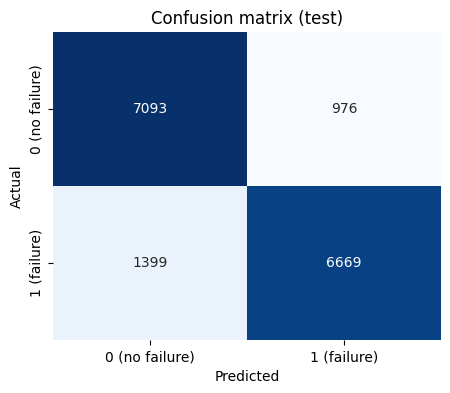

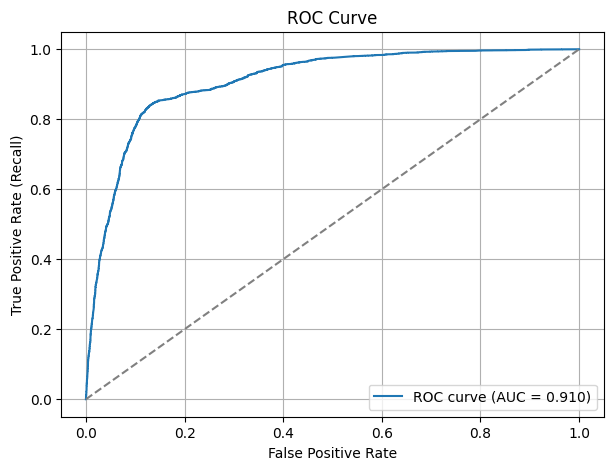

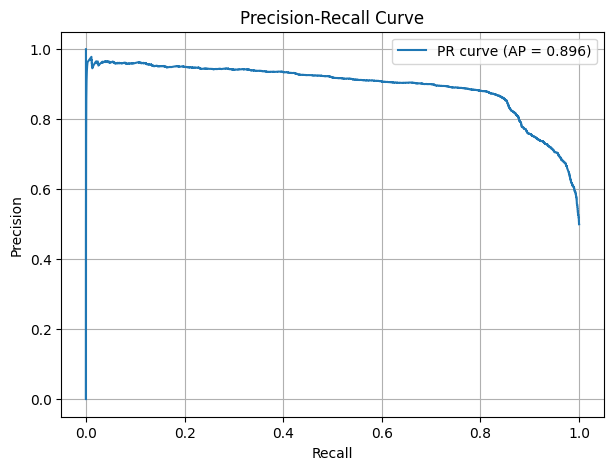

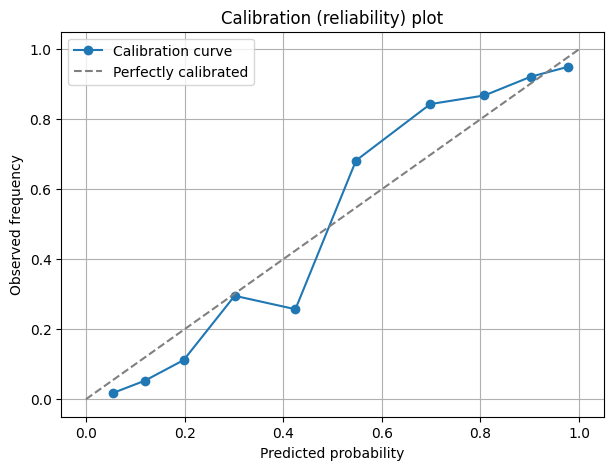


Saved summary metrics to 'model_evaluation_metrics.csv'.
Precision @ top 5% of test = 0.959  (k=806)
Precision @ top 10% of test = 0.950  (k=1613)
Precision @ top 20% of test = 0.936  (k=3227)
Precision @ top 30% of test = 0.913  (k=4841)


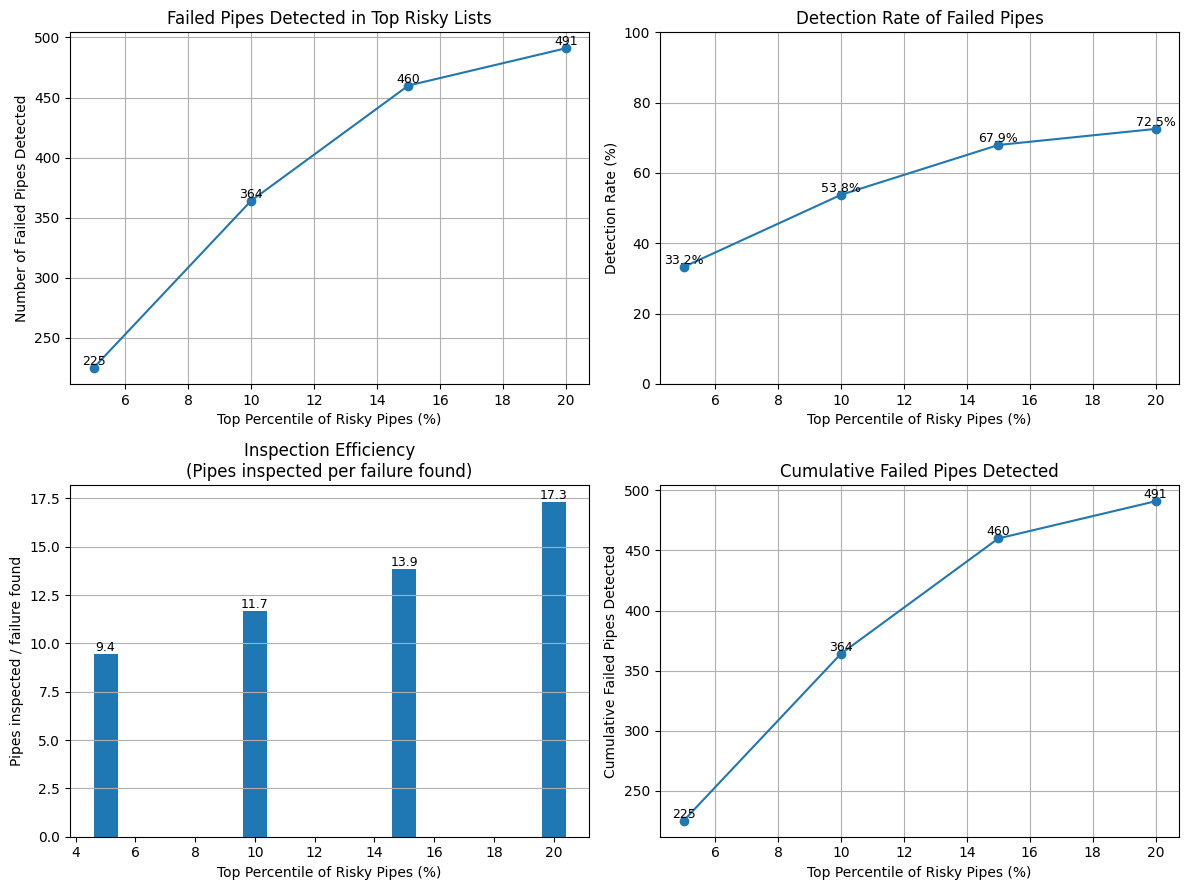


Summary:
 Percentile (%)  Number inspected (k)  Detected failures (top-k)  Detection rate (%)  Pipes inspected per failure
              5                  2125                        225               33.23                         9.44
             10                  4250                        364               53.77                        11.68
             15                  6375                        460               67.95                        13.86
             20                  8501                        491               72.53                        17.31

Saved summary CSV: detection_summary_percentiles.csv


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Split the resampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify=y_resampled)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_scaled = scaler.transform(X)  # Scale original data for final prediction

# Train the model
model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)

# ---- Model evaluation utilities ----
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score,
    brier_score_loss
)
from sklearn.calibration import calibration_curve

# -------------------------
# ASSUMPTION: you already have
# X_train_scaled, X_test (unscaled or scaled?), X_scaled (full dataset scaled),
# y_train, y_test, model, scaler, ids  (IDs for full dataset)
# In your earlier snippet: X_train_scaled = scaler.fit_transform(X_train)
#                           X_scaled = scaler.transform(X)
#                           model.fit(X_train_scaled, y_train)
# So for test predictions, we need to scale X_test
# -------------------------

# 1) Scale X_test same way (if not yet scaled)
X_test_scaled = scaler.transform(X_test)

# 2) Predictions (probabilities) and hard labels (use 0.5 threshold by default)
y_prob_test = model.predict_proba(X_test_scaled)[:, 1]
y_pred_test = (y_prob_test >= 0.5).astype(int)

from sklearn.metrics import classification_report

# --- Full classification report for both classes ---
print("\n=== Full Classification Report (per class) ===")
print(classification_report(
    y_test, 
    y_pred_test,
    target_names=['0 (No Failure)', '1 (Failure)'],
    digits=4
))

# 3) Confusion matrix and core metrics
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test, zero_division=0)
recall = recall_score(y_test, y_pred_test, zero_division=0)   # sensitivity / TPR
f1 = f1_score(y_test, y_pred_test, zero_division=0)
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

# Balanced accuracy: (TP/(TP+FN) + TN/(TN+FP)) / 2
tpr = tp / (tp + fn) if (tp + fn) > 0 else 0.0   # sensitivity
tnr = tn / (tn + fp) if (tn + fp) > 0 else 0.0   # specificity
balanced_acc = 0.5 * (tpr + tnr)

roc_auc = roc_auc_score(y_test, y_prob_test)
pr_auc = average_precision_score(y_test, y_prob_test)  # area under PR curve
brier = brier_score_loss(y_test, y_prob_test)  # calibration measure

# 4) Print metrics neatly
print("=== Confusion matrix (threshold=0.5) ===")
print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")
print()
print("=== Classification metrics ===")
print(f"Accuracy        : {accuracy:.4f}")
print(f"Balanced acc    : {balanced_acc:.4f}  (=(Sensitivity+Specificity)/2)")
print(f"Sensitivity (TPR): {tpr:.4f}")
print(f"Specificity (TNR): {tnr:.4f}")
print(f"Precision (PPV) : {precision:.4f}")
print(f"F1-score        : {f1:.4f}")
print()
print("=== Probabilistic metrics ===")
print(f"ROC AUC         : {roc_auc:.4f}")
print(f"PR AUC (AP)     : {pr_auc:.4f}")
print(f"Brier score     : {brier:.4f} (lower better, calibration)")

# 5) Confusion matrix heatmap
plt.figure(figsize=(5,4))
cm = np.array([[tn, fp],[fn, tp]])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion matrix (test)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5,1.5], ['0 (no failure)','1 (failure)'])
plt.yticks([0.5,1.5], ['0 (no failure)','1 (failure)'])
plt.show()

# 6) ROC curve
fpr, tpr_curve, thresholds = roc_curve(y_test, y_prob_test)
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr_curve, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

# 7) Precision-Recall curve
precision_vals, recall_vals, pr_thresh = precision_recall_curve(y_test, y_prob_test)
plt.figure(figsize=(7,5))
plt.plot(recall_vals, precision_vals, label=f'PR curve (AP = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

# 8) Calibration / Reliability diagram
prob_true, prob_pred = calibration_curve(y_test, y_prob_test, n_bins=10, strategy='quantile')
plt.figure(figsize=(7,5))
plt.plot(prob_pred, prob_true, marker='o', label='Calibration curve')
plt.plot([0,1],[0,1], '--', color='gray', label='Perfectly calibrated')
plt.xlabel('Predicted probability')
plt.ylabel('Observed frequency')
plt.title('Calibration (reliability) plot')
plt.legend()
plt.grid(True)
plt.show()

# 9) Optional: save metrics to dict/CSV
metrics = {
    'accuracy': accuracy,
    'balanced_accuracy': balanced_acc,
    'sensitivity': tpr,
    'specificity': tnr,
    'precision': precision,
    'f1': f1,
    'roc_auc': roc_auc,
    'pr_auc': pr_auc,
    'brier_score': brier,
    'n_test': len(y_test),
    'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn
}
metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv('model_evaluation_metrics.csv', index=False)
print("\nSaved summary metrics to 'model_evaluation_metrics.csv'.")

# 10) Precision@k (helpful for top-k prioritization)
# Example: what fraction of top 20% predicted (by prob on full X_scaled) actually are failures in test set?
# Note: this requires linking IDs of predictions to true future outcomes; adapt if needed.

# If you want Precision@K on the test set:
test_probs = y_prob_test  # probabilities for test rows
test_ids = getattr(X_test, 'index', None)  # if X_test is DataFrame, index holds IDs; else skip
# Compute top-k fraction within test set (k fractions)
for frac in [0.05, 0.1, 0.2, 0.3]:
    k = max(1, int(len(test_probs) * frac))
    topk_idx = np.argsort(test_probs)[-k:]
    topk_true = np.array(y_test)[topk_idx]
    prec_at_k = topk_true.sum() / k
    print(f"Precision @ top {int(frac*100)}% of test = {prec_at_k:.3f}  (k={k})")
    
    
# Required imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------
# Inputs (replace with your objects if names differ)
# -------------------------
# risk_assessment: DataFrame with columns ['ID', 'Failure_Probability'] sorted descending
# df2: DataFrame with actual future failures. Either contains 'ID' for failed pipes,
#      or contains 'ID' and 'failed' (0/1) column.

# Example placeholders (comment out if you already have the variables):
# risk_assessment = pd.read_csv("riskiest_pipes.csv")  # ensure sorted descending by Failure_Probability
# df2 = pd.read_csv("df2.csv")

# Ensure ID column is string (safe matching)
risk_assessment['ID'] = risk_assessment['ID'].astype(str)
df2['ID'] = df2['ID'].astype(str)

# Build set of failed IDs from df2
if 'failed' in df2.columns:
    failed_ids = set(df2.loc[df2['failed'] == 1, 'ID'].astype(str))
else:
    failed_ids = set(df2['ID'].astype(str))

# Universe size (number of pipes predicted)
N_total = len(risk_assessment)

# Percentiles to evaluate
percentiles = [5, 10, 15, 20]

# Arrays to store metrics
n_inspected_list = []
n_failed_detected_list = []
detection_rate_pct_list = []
inspection_efficiency_list = []
cumulative_detected_list = []

# Total actual failures in df2 (within universe) - intersect with universe to be strict
universe_ids = list(risk_assessment['ID'].astype(str))
failed_ids_in_universe = set(universe_ids).intersection(failed_ids)
total_failures = len(failed_ids_in_universe)

# Keep cumulative detected as we expand percentiles (use increasing percentiles order)
cumulative_detected = 0
for p in percentiles:
    k = max(1, int(np.floor(N_total * (p / 100.0))))  # number of pipes inspected at this percentile
    topk_ids = set(risk_assessment.head(k)['ID'].astype(str))
    # detected failures among these top-k
    detected = len(topk_ids.intersection(failed_ids_in_universe))
    cumulative_detected = detected  # since percentiles are increasing, "detected" is for that top-k; if you want cumulative across steps (5 then + next 5), see note below.
    # If you instead want incremental per-segment detection, you'd compute difference from previous k; in plots we usually show cumulative top-k detection (i.e., detected in top k)
    # detection rate relative to total actual failures
    detection_rate_pct = (detected / total_failures * 100) if total_failures > 0 else 0.0
    # inspection efficiency = pipes inspected per failure found (k / detected); guard div by zero
    inspection_efficiency = (k / detected) if detected > 0 else np.nan

    # store
    n_inspected_list.append(k)
    n_failed_detected_list.append(detected)
    detection_rate_pct_list.append(detection_rate_pct)
    inspection_efficiency_list.append(inspection_efficiency)
    cumulative_detected_list.append(detected)  # this is cumulative top-k detection

# If percentiles were not sorted, ensure to sort by percentile for plotting
# (they are sorted here: [5,10,15,20])

# -------------------------
# Create 4-panel figure (2x2)
# -------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 9))
axes = axes.ravel()

# 1) Failed Pipes Detected in Top Risky Lists (absolute number)
axes[0].plot(percentiles, n_failed_detected_list, marker='o')
for x, y in zip(percentiles, n_failed_detected_list):
    axes[0].text(x, y, str(y), fontsize=9, ha='center', va='bottom')
axes[0].set_title('Failed Pipes Detected in Top Risky Lists')
axes[0].set_xlabel('Top Percentile of Risky Pipes (%)')
axes[0].set_ylabel('Number of Failed Pipes Detected')
axes[0].grid(True)

# 2) Detection Rate of Failed Pipes (%)
axes[1].plot(percentiles, detection_rate_pct_list, marker='o')
for x, y in zip(percentiles, detection_rate_pct_list):
    axes[1].text(x, y, f"{y:.1f}%", fontsize=9, ha='center', va='bottom')
axes[1].set_title('Detection Rate of Failed Pipes')
axes[1].set_xlabel('Top Percentile of Risky Pipes (%)')
axes[1].set_ylabel('Detection Rate (%)')
axes[1].set_ylim(0, 100)
axes[1].grid(True)

# 3) Inspection Efficiency (pipes inspected per failure found)
axes[2].bar(percentiles, inspection_efficiency_list)
for x, y in zip(percentiles, inspection_efficiency_list):
    label = f"{y:.1f}" if not np.isnan(y) else "inf"
    axes[2].text(x, y if not np.isnan(y) else 0, label, fontsize=9, ha='center', va='bottom')
axes[2].set_title('Inspection Efficiency\n(Pipes inspected per failure found)')
axes[2].set_xlabel('Top Percentile of Risky Pipes (%)')
axes[2].set_ylabel('Pipes inspected / failure found')
axes[2].grid(axis='y')

# 4) Cumulative Failed Pipes Detected (same as 1 here: detection vs top-k)
axes[3].plot(percentiles, cumulative_detected_list, marker='o')
for x, y in zip(percentiles, cumulative_detected_list):
    axes[3].text(x, y, str(y), fontsize=9, ha='center', va='bottom')
axes[3].set_title('Cumulative Failed Pipes Detected')
axes[3].set_xlabel('Top Percentile of Risky Pipes (%)')
axes[3].set_ylabel('Cumulative Failed Pipes Detected')
axes[3].grid(True)

plt.tight_layout()
plt.show()

# -------------------------
# Print summary table
# -------------------------
summary_df = pd.DataFrame({
    "Percentile (%)": percentiles,
    "Number inspected (k)": n_inspected_list,
    "Detected failures (top-k)": n_failed_detected_list,
    "Detection rate (%)": [round(x, 2) for x in detection_rate_pct_list],
    "Pipes inspected per failure": [ (round(x,2) if (not np.isnan(x)) else None) for x in inspection_efficiency_list ]
})
print("\nSummary:")
print(summary_df.to_string(index=False))

# -------------------------
# Save results
# -------------------------
summary_df.to_csv("detection_summary_percentiles.csv", index=False)
print("\nSaved summary CSV: detection_summary_percentiles.csv")



In [22]:
# # Required imports
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# # -------------------------
# # Inputs (replace with your objects if names differ)
# # -------------------------
# # risk_assessment: DataFrame with columns ['ID', 'Failure_Probability'] sorted descending
# # df2: DataFrame with actual future failures. Either contains 'ID' for failed pipes,
# #      or contains 'ID' and 'failed' (0/1) column.

# # Example placeholders (comment out if you already have the variables):
# # risk_assessment = pd.read_csv("riskiest_pipes.csv")  # ensure sorted descending by Failure_Probability
# # df2 = pd.read_csv("df2.csv")

# # Ensure ID column is string (safe matching)
# risk_assessment['ID'] = risk_assessment['ID'].astype(str)
# df2['ID'] = df2['ID'].astype(str)

# # Build set of failed IDs from df2
# if 'failed' in df2.columns:
#     failed_ids = set(df2.loc[df2['failed'] == 1, 'ID'].astype(str))
# else:
#     failed_ids = set(df2['ID'].astype(str))

# # Universe size (number of pipes predicted)
# N_total = len(risk_assessment)

# # Percentiles to evaluate
# percentiles = [5, 10, 15, 20]

# # Arrays to store metrics
# n_inspected_list = []
# n_failed_detected_list = []
# detection_rate_pct_list = []
# inspection_efficiency_list = []
# cumulative_detected_list = []

# # Total actual failures in df2 (within universe) - intersect with universe to be strict
# universe_ids = list(risk_assessment['ID'].astype(str))
# failed_ids_in_universe = set(universe_ids).intersection(failed_ids)
# total_failures = len(failed_ids_in_universe)

# # Keep cumulative detected as we expand percentiles (use increasing percentiles order)
# cumulative_detected = 0
# for p in percentiles:
#     k = max(1, int(np.floor(N_total * (p / 100.0))))  # number of pipes inspected at this percentile
#     topk_ids = set(risk_assessment.head(k)['ID'].astype(str))
#     # detected failures among these top-k
#     detected = len(topk_ids.intersection(failed_ids_in_universe))
#     cumulative_detected = detected  # since percentiles are increasing, "detected" is for that top-k; if you want cumulative across steps (5 then + next 5), see note below.
#     # If you instead want incremental per-segment detection, you'd compute difference from previous k; in plots we usually show cumulative top-k detection (i.e., detected in top k)
#     # detection rate relative to total actual failures
#     detection_rate_pct = (detected / total_failures * 100) if total_failures > 0 else 0.0
#     # inspection efficiency = pipes inspected per failure found (k / detected); guard div by zero
#     inspection_efficiency = (k / detected) if detected > 0 else np.nan

#     # store
#     n_inspected_list.append(k)
#     n_failed_detected_list.append(detected)
#     detection_rate_pct_list.append(detection_rate_pct)
#     inspection_efficiency_list.append(inspection_efficiency)
#     cumulative_detected_list.append(detected)  # this is cumulative top-k detection

# # If percentiles were not sorted, ensure to sort by percentile for plotting
# # (they are sorted here: [5,10,15,20])

# # -------------------------
# # Create 4-panel figure (2x2)
# # -------------------------
# fig, axes = plt.subplots(2, 2, figsize=(12, 9))
# axes = axes.ravel()

# # 1) Failed Pipes Detected in Top Risky Lists (absolute number)
# axes[0].plot(percentiles, n_failed_detected_list, marker='o')
# for x, y in zip(percentiles, n_failed_detected_list):
#     axes[0].text(x, y, str(y), fontsize=9, ha='center', va='bottom')
# axes[0].set_title('Failed Pipes Detected in Top Risky Lists')
# axes[0].set_xlabel('Top Percentile of Risky Pipes (%)')
# axes[0].set_ylabel('Number of Failed Pipes Detected')
# axes[0].grid(True)

# # 2) Detection Rate of Failed Pipes (%)
# axes[1].plot(percentiles, detection_rate_pct_list, marker='o')
# for x, y in zip(percentiles, detection_rate_pct_list):
#     axes[1].text(x, y, f"{y:.1f}%", fontsize=9, ha='center', va='bottom')
# axes[1].set_title('Detection Rate of Failed Pipes')
# axes[1].set_xlabel('Top Percentile of Risky Pipes (%)')
# axes[1].set_ylabel('Detection Rate (%)')
# axes[1].set_ylim(0, 100)
# axes[1].grid(True)

# # 3) Inspection Efficiency (pipes inspected per failure found)
# axes[2].bar(percentiles, inspection_efficiency_list)
# for x, y in zip(percentiles, inspection_efficiency_list):
#     label = f"{y:.1f}" if not np.isnan(y) else "inf"
#     axes[2].text(x, y if not np.isnan(y) else 0, label, fontsize=9, ha='center', va='bottom')
# axes[2].set_title('Inspection Efficiency\n(Pipes inspected per failure found)')
# axes[2].set_xlabel('Top Percentile of Risky Pipes (%)')
# axes[2].set_ylabel('Pipes inspected / failure found')
# axes[2].grid(axis='y')

# # 4) Cumulative Failed Pipes Detected (same as 1 here: detection vs top-k)
# axes[3].plot(percentiles, cumulative_detected_list, marker='o')
# for x, y in zip(percentiles, cumulative_detected_list):
#     axes[3].text(x, y, str(y), fontsize=9, ha='center', va='bottom')
# axes[3].set_title('Cumulative Failed Pipes Detected')
# axes[3].set_xlabel('Top Percentile of Risky Pipes (%)')
# axes[3].set_ylabel('Cumulative Failed Pipes Detected')
# axes[3].grid(True)

# plt.tight_layout()
# plt.show()

# # -------------------------
# # Print summary table
# # -------------------------
# summary_df = pd.DataFrame({
#     "Percentile (%)": percentiles,
#     "Number inspected (k)": n_inspected_list,
#     "Detected failures (top-k)": n_failed_detected_list,
#     "Detection rate (%)": [round(x, 2) for x in detection_rate_pct_list],
#     "Pipes inspected per failure": [ (round(x,2) if (not np.isnan(x)) else None) for x in inspection_efficiency_list ]
# })
# print("\nSummary:")
# print(summary_df.to_string(index=False))

# # -------------------------
# # Save results
# # -------------------------
# summary_df.to_csv("detection_summary_percentiles.csv", index=False)
# print("\nSaved summary CSV: detection_summary_percentiles.csv")


### Random Forest


=== Full Classification Report (per class) ===
                precision    recall  f1-score   support

0 (No Failure)     0.9332    0.9370    0.9351      8069
   1 (Failure)     0.9368    0.9329    0.9349      8068

      accuracy                         0.9350     16137
     macro avg     0.9350    0.9350    0.9350     16137
  weighted avg     0.9350    0.9350    0.9350     16137

=== Confusion matrix (threshold=0.5) ===
TN: 7561, FP: 508, FN: 541, TP: 7527

=== Classification metrics ===
Accuracy        : 0.9350
Balanced acc    : 0.9350  (=(Sensitivity+Specificity)/2)
Sensitivity (TPR): 0.9329
Specificity (TNR): 0.9370
Precision (PPV) : 0.9368
F1-score        : 0.9349

=== Probabilistic metrics ===
ROC AUC         : 0.9762
PR AUC (AP)     : 0.9690
Brier score     : 0.0494 (lower better, calibration)

=== Random Forest Specific Info ===
Number of trees : 100
OOB not enabled


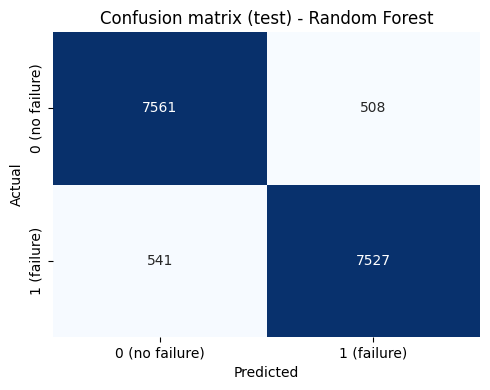

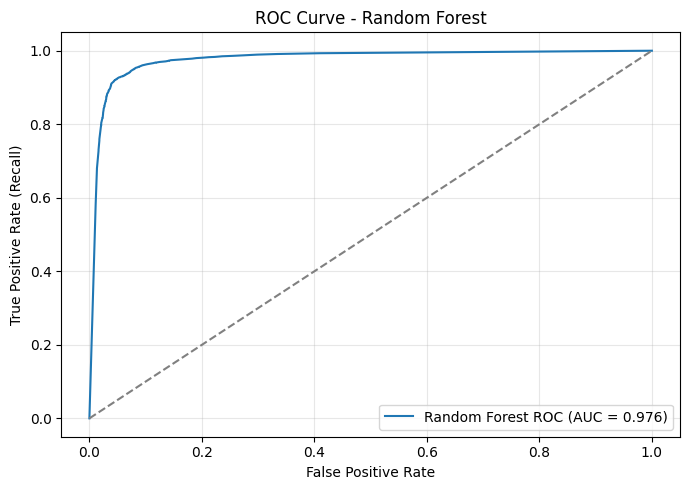

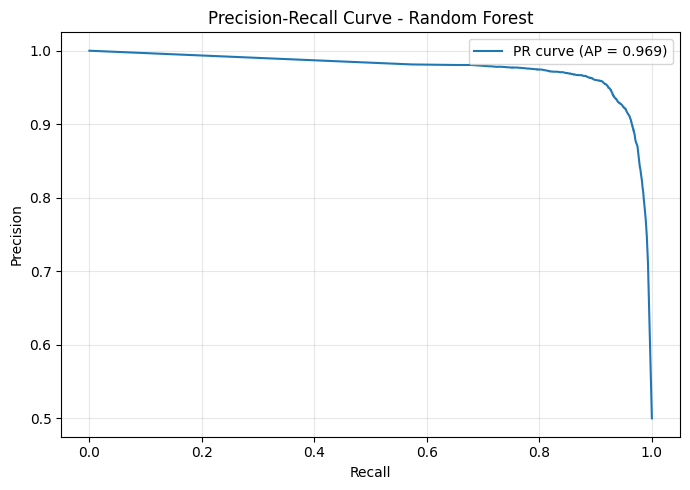

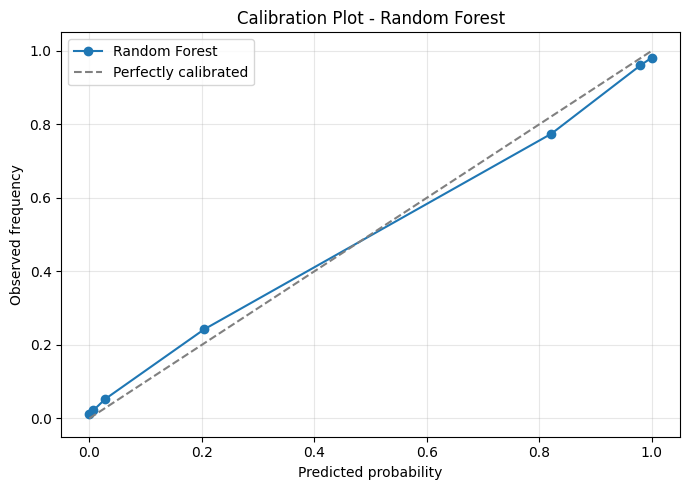

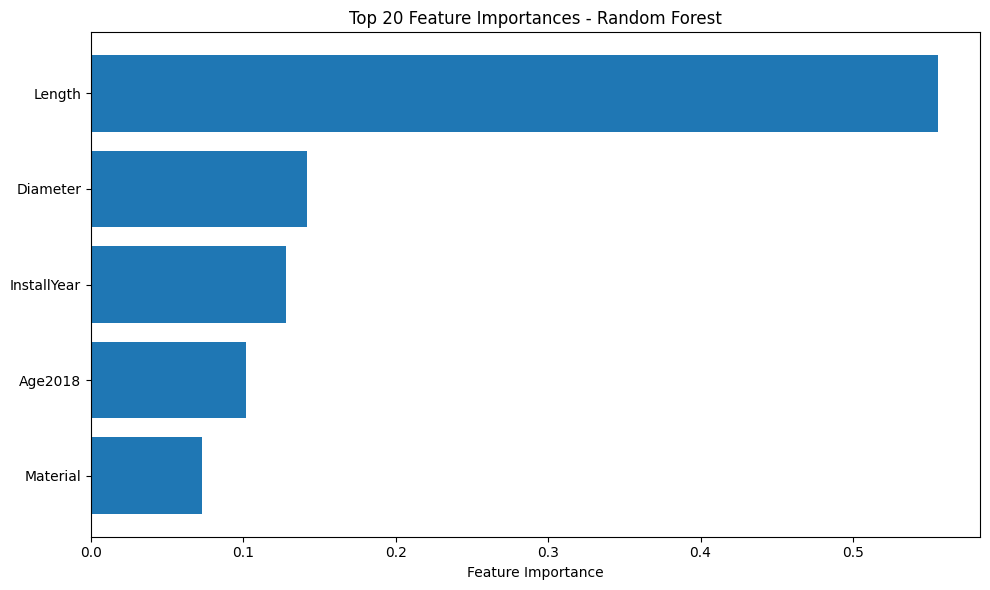


=== Top 10 Feature Importances ===
    feature  importance
     Length    0.555602
   Diameter    0.141778
InstallYear    0.127981
    Age2018    0.101745
   Material    0.072893

Saved summary metrics to 'random_forest_evaluation_metrics.csv'.
Saved risk assessment for 42505 pipes

=== Precision@K Analysis ===
Precision @ top 5% of test = 0.988  (k=806)
Precision @ top 10% of test = 0.978  (k=1613)
Precision @ top 15% of test = 0.980  (k=2420)
Precision @ top 20% of test = 0.980  (k=3227)
Precision @ top 25% of test = 0.980  (k=4034)
Precision @ top 30% of test = 0.981  (k=4841)

=== Detection Analysis ===
Total pipes in assessment: 42505
Total failures in universe: 677


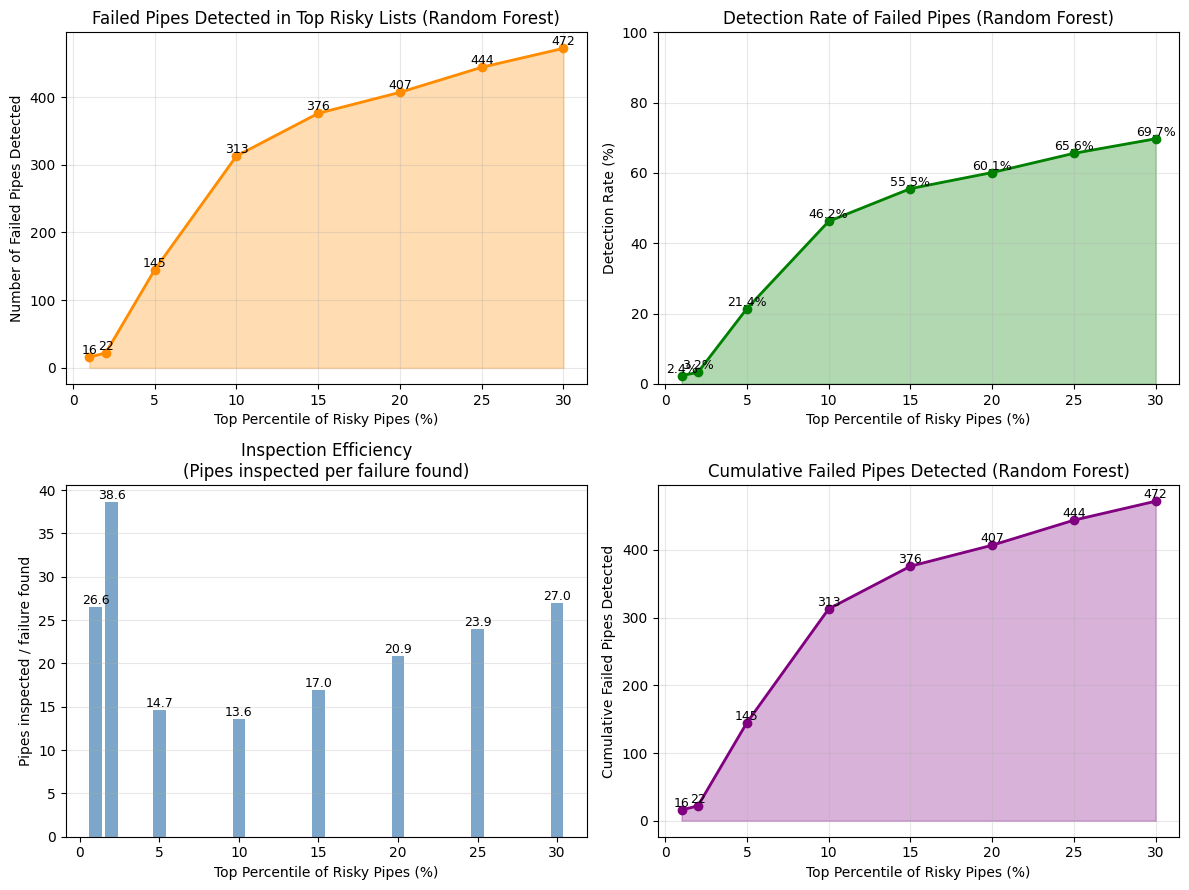


=== Detection Summary ===
 Percentile (%)  Number inspected (k)  Detected failures (top-k)  Detection rate (%)  Pipes inspected per failure
              1                   425                         16                2.36                        26.56
              2                   850                         22                3.25                        38.64
              5                  2125                        145               21.42                        14.66
             10                  4250                        313               46.23                        13.58
             15                  6375                        376               55.54                        16.95
             20                  8501                        407               60.12                        20.89
             25                 10626                        444               65.58                        23.93
             30                 12751                        

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Split the resampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify=y_resampled)

# Note: Random Forest doesn't require scaling, but we'll keep it for consistency
# with your original pipeline. Consider removing scaling for Random Forest.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_scaled = scaler.transform(X)  # Scale original data for final prediction

# Train the Random Forest model
model = RandomForestClassifier(
    n_estimators=100,           # Number of trees in the forest
    max_depth=None,             # No maximum depth (trees grow until pure)
    min_samples_split=2,        # Minimum samples to split a node
    min_samples_leaf=1,         # Minimum samples in a leaf node
    max_features='sqrt',        # Number of features to consider for best split
    bootstrap=True,             # Bootstrap samples when building trees
    class_weight='balanced',    # Adjust weights inversely proportional to class frequencies
    random_state=42,            # For reproducibility
    n_jobs=-1,                  # Use all available CPU cores
    verbose=0                   # No training progress output
)

model.fit(X_train_scaled, y_train)

# ---- Model evaluation utilities ----
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score,
    brier_score_loss
)
from sklearn.calibration import calibration_curve

# -------------------------
# ASSUMPTION: you already have
# X_train_scaled, X_test (unscaled or scaled?), X_scaled (full dataset scaled),
# y_train, y_test, model, scaler, ids  (IDs for full dataset)
# In your earlier snippet: X_train_scaled = scaler.fit_transform(X_train)
#                           X_scaled = scaler.transform(X)
#                           model.fit(X_train_scaled, y_train)
# So for test predictions, we need to scale X_test
# -------------------------

# 1) Scale X_test same way (if not yet scaled)
X_test_scaled = scaler.transform(X_test)

# 2) Predictions (probabilities) and hard labels (use 0.5 threshold by default)
y_prob_test = model.predict_proba(X_test_scaled)[:, 1]
y_pred_test = (y_prob_test >= 0.5).astype(int)

from sklearn.metrics import classification_report

# --- Full classification report for both classes ---
print("\n=== Full Classification Report (per class) ===")
print(classification_report(
    y_test, 
    y_pred_test,
    target_names=['0 (No Failure)', '1 (Failure)'],
    digits=4
))

# 3) Confusion matrix and core metrics
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test, zero_division=0)
recall = recall_score(y_test, y_pred_test, zero_division=0)   # sensitivity / TPR
f1 = f1_score(y_test, y_pred_test, zero_division=0)
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

# Balanced accuracy: (TP/(TP+FN) + TN/(TN+FP)) / 2
tpr = tp / (tp + fn) if (tp + fn) > 0 else 0.0   # sensitivity
tnr = tn / (tn + fp) if (tn + fp) > 0 else 0.0   # specificity
balanced_acc = 0.5 * (tpr + tnr)

roc_auc = roc_auc_score(y_test, y_prob_test)
pr_auc = average_precision_score(y_test, y_prob_test)  # area under PR curve
brier = brier_score_loss(y_test, y_prob_test)  # calibration measure

# 4) Print metrics neatly
print("=== Confusion matrix (threshold=0.5) ===")
print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")
print()
print("=== Classification metrics ===")
print(f"Accuracy        : {accuracy:.4f}")
print(f"Balanced acc    : {balanced_acc:.4f}  (=(Sensitivity+Specificity)/2)")
print(f"Sensitivity (TPR): {tpr:.4f}")
print(f"Specificity (TNR): {tnr:.4f}")
print(f"Precision (PPV) : {precision:.4f}")
print(f"F1-score        : {f1:.4f}")
print()
print("=== Probabilistic metrics ===")
print(f"ROC AUC         : {roc_auc:.4f}")
print(f"PR AUC (AP)     : {pr_auc:.4f}")
print(f"Brier score     : {brier:.4f} (lower better, calibration)")
print()
print("=== Random Forest Specific Info ===")
print(f"Number of trees : {model.n_estimators}")
print(f"OOB score       : {model.oob_score_:.4f}" if hasattr(model, 'oob_score_') else "OOB not enabled")

# 5) Confusion matrix heatmap
plt.figure(figsize=(5,4))
cm = np.array([[tn, fp],[fn, tp]])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion matrix (test) - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5,1.5], ['0 (no failure)','1 (failure)'])
plt.yticks([0.5,1.5], ['0 (no failure)','1 (failure)'])
plt.tight_layout()
plt.show()

# 6) ROC curve
fpr, tpr_curve, thresholds = roc_curve(y_test, y_prob_test)
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr_curve, label=f'Random Forest ROC (AUC = {roc_auc:.3f})')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve - Random Forest')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 7) Precision-Recall curve
precision_vals, recall_vals, pr_thresh = precision_recall_curve(y_test, y_prob_test)
plt.figure(figsize=(7,5))
plt.plot(recall_vals, precision_vals, label=f'PR curve (AP = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Random Forest')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 8) Calibration / Reliability diagram
prob_true, prob_pred = calibration_curve(y_test, y_prob_test, n_bins=10, strategy='quantile')
plt.figure(figsize=(7,5))
plt.plot(prob_pred, prob_true, marker='o', label='Random Forest')
plt.plot([0,1],[0,1], '--', color='gray', label='Perfectly calibrated')
plt.xlabel('Predicted probability')
plt.ylabel('Observed frequency')
plt.title('Calibration Plot - Random Forest')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 9) Feature Importance (Random Forest specific)
if hasattr(model, 'feature_importances_'):
    feature_names = X.columns if hasattr(X, 'columns') else [f'Feature_{i}' for i in range(X.shape[1])]
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    plt.barh(range(min(20, len(feature_importance))), 
             feature_importance['importance'][:20][::-1])
    plt.yticks(range(min(20, len(feature_importance))), 
               feature_importance['feature'][:20][::-1])
    plt.xlabel('Feature Importance')
    plt.title('Top 20 Feature Importances - Random Forest')
    plt.tight_layout()
    plt.show()
    
    print("\n=== Top 10 Feature Importances ===")
    print(feature_importance.head(10).to_string(index=False))

# 10) Optional: save metrics to dict/CSV
metrics = {
    'model': 'Random Forest',
    'accuracy': accuracy,
    'balanced_accuracy': balanced_acc,
    'sensitivity': tpr,
    'specificity': tnr,
    'precision': precision,
    'f1': f1,
    'roc_auc': roc_auc,
    'pr_auc': pr_auc,
    'brier_score': brier,
    'n_test': len(y_test),
    'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn,
    'n_estimators': model.n_estimators,
    'oob_score': model.oob_score_ if hasattr(model, 'oob_score_') else None
}
metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv('random_forest_evaluation_metrics.csv', index=False)
print("\nSaved summary metrics to 'random_forest_evaluation_metrics.csv'.")

# 11) Generate risk assessment for all pipes
y_prob_all = model.predict_proba(X_scaled)[:, 1]
risk_assessment = pd.DataFrame({
    'ID': ids,  # Assuming you have IDs for all pipes
    'Failure_Probability': y_prob_all
}).sort_values('Failure_Probability', ascending=False)

# Save risk assessment
risk_assessment.to_csv('risk_assessment_random_forest.csv', index=False)
print(f"Saved risk assessment for {len(risk_assessment)} pipes")

# 12) Precision@k (helpful for top-k prioritization)
print("\n=== Precision@K Analysis ===")
test_probs = y_prob_test
for frac in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]:
    k = max(1, int(len(test_probs) * frac))
    topk_idx = np.argsort(test_probs)[-k:]
    topk_true = np.array(y_test)[topk_idx]
    prec_at_k = topk_true.sum() / k
    print(f"Precision @ top {int(frac*100)}% of test = {prec_at_k:.3f}  (k={k})")

# 13) Detection analysis (assuming you have df2 with actual failures)
print("\n=== Detection Analysis ===")

# Required imports (if not already imported)
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# -------------------------
# Inputs (replace with your objects if names differ)
# -------------------------
# risk_assessment: DataFrame with columns ['ID', 'Failure_Probability'] sorted descending
# df2: DataFrame with actual future failures. Either contains 'ID' for failed pipes,
#      or contains 'ID' and 'failed' (0/1) column.

# Ensure ID column is string (safe matching)
risk_assessment['ID'] = risk_assessment['ID'].astype(str)
df2['ID'] = df2['ID'].astype(str)

# Build set of failed IDs from df2
if 'failed' in df2.columns:
    failed_ids = set(df2.loc[df2['failed'] == 1, 'ID'].astype(str))
else:
    failed_ids = set(df2['ID'].astype(str))

# Universe size (number of pipes predicted)
N_total = len(risk_assessment)

# Percentiles to evaluate
percentiles = [1, 2, 5, 10, 15, 20, 25, 30]

# Arrays to store metrics
n_inspected_list = []
n_failed_detected_list = []
detection_rate_pct_list = []
inspection_efficiency_list = []
cumulative_detected_list = []

# Total actual failures in df2 (within universe) - intersect with universe to be strict
universe_ids = list(risk_assessment['ID'].astype(str))
failed_ids_in_universe = set(universe_ids).intersection(failed_ids)
total_failures = len(failed_ids_in_universe)

print(f"Total pipes in assessment: {N_total}")
print(f"Total failures in universe: {total_failures}")

# Keep cumulative detected as we expand percentiles
cumulative_detected = 0
for p in percentiles:
    k = max(1, int(np.floor(N_total * (p / 100.0))))
    topk_ids = set(risk_assessment.head(k)['ID'].astype(str))
    # detected failures among these top-k
    detected = len(topk_ids.intersection(failed_ids_in_universe))
    
    # detection rate relative to total actual failures
    detection_rate_pct = (detected / total_failures * 100) if total_failures > 0 else 0.0
    # inspection efficiency = pipes inspected per failure found
    inspection_efficiency = (k / detected) if detected > 0 else np.nan

    # store
    n_inspected_list.append(k)
    n_failed_detected_list.append(detected)
    detection_rate_pct_list.append(detection_rate_pct)
    inspection_efficiency_list.append(inspection_efficiency)
    cumulative_detected_list.append(detected)

# -------------------------
# Create 4-panel figure (2x2)
# -------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 9))
axes = axes.ravel()

# 1) Failed Pipes Detected in Top Risky Lists (absolute number)
axes[0].plot(percentiles, n_failed_detected_list, marker='o', color='darkorange', linewidth=2)
for x, y in zip(percentiles, n_failed_detected_list):
    axes[0].text(x, y, str(y), fontsize=9, ha='center', va='bottom')
axes[0].set_title('Failed Pipes Detected in Top Risky Lists (Random Forest)')
axes[0].set_xlabel('Top Percentile of Risky Pipes (%)')
axes[0].set_ylabel('Number of Failed Pipes Detected')
axes[0].grid(True, alpha=0.3)
axes[0].fill_between(percentiles, 0, n_failed_detected_list, alpha=0.3, color='darkorange')

# 2) Detection Rate of Failed Pipes (%)
axes[1].plot(percentiles, detection_rate_pct_list, marker='o', color='green', linewidth=2)
for x, y in zip(percentiles, detection_rate_pct_list):
    axes[1].text(x, y, f"{y:.1f}%", fontsize=9, ha='center', va='bottom')
axes[1].set_title('Detection Rate of Failed Pipes (Random Forest)')
axes[1].set_xlabel('Top Percentile of Risky Pipes (%)')
axes[1].set_ylabel('Detection Rate (%)')
axes[1].set_ylim(0, 100)
axes[1].grid(True, alpha=0.3)
axes[1].fill_between(percentiles, 0, detection_rate_pct_list, alpha=0.3, color='green')

# 3) Inspection Efficiency (pipes inspected per failure found)
axes[2].bar(percentiles, inspection_efficiency_list, color='steelblue', alpha=0.7)
for x, y in zip(percentiles, inspection_efficiency_list):
    label = f"{y:.1f}" if not np.isnan(y) else "inf"
    axes[2].text(x, y if not np.isnan(y) else 0, label, fontsize=9, ha='center', va='bottom')
axes[2].set_title('Inspection Efficiency\n(Pipes inspected per failure found)')
axes[2].set_xlabel('Top Percentile of Risky Pipes (%)')
axes[2].set_ylabel('Pipes inspected / failure found')
axes[2].grid(axis='y', alpha=0.3)

# 4) Cumulative Failed Pipes Detected
axes[3].plot(percentiles, cumulative_detected_list, marker='o', color='purple', linewidth=2)
for x, y in zip(percentiles, cumulative_detected_list):
    axes[3].text(x, y, str(y), fontsize=9, ha='center', va='bottom')
axes[3].set_title('Cumulative Failed Pipes Detected (Random Forest)')
axes[3].set_xlabel('Top Percentile of Risky Pipes (%)')
axes[3].set_ylabel('Cumulative Failed Pipes Detected')
axes[3].grid(True, alpha=0.3)
axes[3].fill_between(percentiles, 0, cumulative_detected_list, alpha=0.3, color='purple')

plt.tight_layout()
plt.show()

# -------------------------
# Print summary table
# -------------------------
summary_df = pd.DataFrame({
    "Percentile (%)": percentiles,
    "Number inspected (k)": n_inspected_list,
    "Detected failures (top-k)": n_failed_detected_list,
    "Detection rate (%)": [round(x, 2) for x in detection_rate_pct_list],
    "Pipes inspected per failure": [round(x, 2) if not np.isnan(x) else np.inf for x in inspection_efficiency_list]
})
print("\n=== Detection Summary ===")
print(summary_df.to_string(index=False))

# -------------------------
# Save results
# -------------------------
summary_df.to_csv("detection_summary_random_forest.csv", index=False)
print("\nSaved detection summary to: detection_summary_random_forest.csv")

# 14) Optional: Feature importance to CSV
if hasattr(model, 'feature_importances_'):
    feature_importance.to_csv('random_forest_feature_importance.csv', index=False)
    print("Saved feature importance to: random_forest_feature_importance.csv")

In [27]:
!pip install xgboost lightgbm catboost scikit-learn pandas numpy matplotlib seaborn tqdm


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [29]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


In [31]:
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier
)
from sklearn.neural_network import MLPClassifier


🚀 Training Multiple Models...


Models:   0%|          | 0/8 [00:00<?, ?it/s]


📊 Training Random Forest...
   ✅ Random Forest: ROC AUC = 0.9764, F1 = 0.9347

📊 Training XGBoost...
   ✅ XGBoost: ROC AUC = 0.9757, F1 = 0.9250

📊 Training LightGBM...
   ✅ LightGBM: ROC AUC = 0.9683, F1 = 0.9131

📊 Training CatBoost...
   ✅ CatBoost: ROC AUC = 0.9676, F1 = 0.9118

📊 Training SVM...
   ✅ SVM: ROC AUC = 0.8644, F1 = 0.7938

📊 Training Gradient Boosting...
   ✅ Gradient Boosting: ROC AUC = 0.9442, F1 = 0.8880

📊 Training AdaBoost...
   ✅ AdaBoost: ROC AUC = 0.9066, F1 = 0.8392

📊 Training MLP...
   ✅ MLP: ROC AUC = 0.8859, F1 = 0.8136

📈 MODEL PERFORMANCE SUMMARY


,Accuracy,F1-Score,Precision,Recall,ROC AUC,Train Time (s)
Random Forest,0.9348,0.9347,0.9361,0.9333,0.9764,nan
XGBoost,0.9251,0.9250,0.9254,0.9246,0.9757,nan
LightGBM,0.9137,0.9131,0.9192,0.9070,0.9683,nan
CatBoost,0.9126,0.9118,0.9195,0.9043,0.9676,nan
Gradient Boosting,0.8883,0.8880,0.8908,0.8851,0.9442,nan
AdaBoost,0.8409,0.8392,0.8481,0.8304,0.9066,nan
MLP,0.8206,0.8136,0.8466,0.7831,0.8859,nan
SVM,0.7891,0.7938,0.7764,0.8120,0.8644,nan


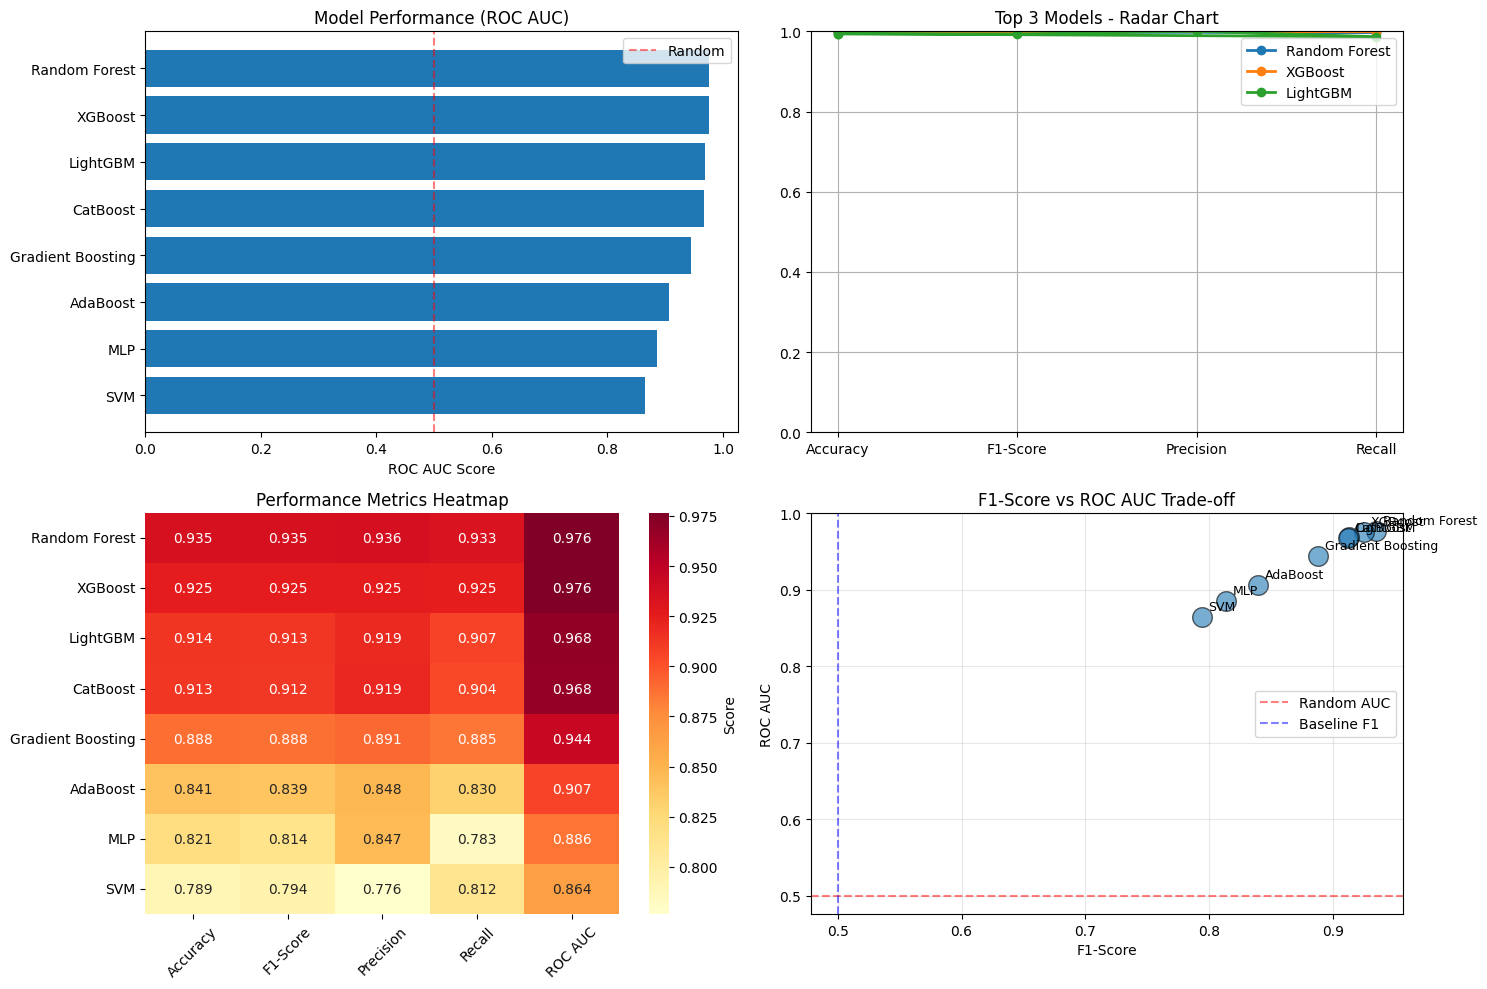


📊 SUMMARY STATISTICS:
Best Model by ROC AUC: Random Forest (0.9764)
Best Model by F1-Score: Random Forest (0.9347)
Mean ROC AUC: 0.9362
Std ROC AUC: 0.0444
Number of models above 0.8 AUC: 8


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score

def test_multiple_models(X_train, X_test, y_train, y_test, show_plots=True):
    """
    Test multiple models with comprehensive evaluation
    """
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
        'XGBoost': XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1, verbosity=0),
        'LightGBM': LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1, verbose=-1),
        'CatBoost': CatBoostClassifier(iterations=100, verbose=False, random_seed=42),
        'SVM': SVC(probability=True, random_state=42, kernel='rbf'),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
        'AdaBoost': AdaBoostClassifier(n_estimators=50, random_state=42),
        'MLP': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=200, random_state=42)
    }
    
    results = {}
    predictions = {}
    models_trained = {}
    
    print("🚀 Training Multiple Models...")
    print("=" * 60)
    
    # Train all models with progress bar
    for name, model in tqdm(models.items(), desc="Models"):
        print(f"\n📊 Training {name}...")
        
        try:
            # Fit model
            model.fit(X_train, y_train)
            
            # Make predictions
            y_pred = model.predict(X_test)
            y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
            
            # Store trained model
            models_trained[name] = model
            
            # Calculate metrics
            metrics = {
                'Accuracy': accuracy_score(y_test, y_pred),
                'F1-Score': f1_score(y_test, y_pred),
                'Precision': precision_score(y_test, y_pred, zero_division=0),
                'Recall': recall_score(y_test, y_pred, zero_division=0),
                'ROC AUC': roc_auc_score(y_test, y_prob) if y_prob is not None else None,
                'Train Time (s)': None  # Could add timing if needed
            }
            
            results[name] = metrics
            predictions[name] = {
                'y_pred': y_pred,
                'y_prob': y_prob
            }
            
            print(f"   ✅ {name}: ROC AUC = {metrics['ROC AUC']:.4f}, F1 = {metrics['F1-Score']:.4f}")
            
        except Exception as e:
            print(f"   ❌ {name} failed: {str(e)}")
            results[name] = {metric: None for metric in ['Accuracy', 'F1-Score', 'Precision', 'Recall', 'ROC AUC']}
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results).T
    
    # Sort by ROC AUC (descending)
    results_df = results_df.sort_values('ROC AUC', ascending=False)
    
    # Display results
    print("\n" + "=" * 60)
    print("📈 MODEL PERFORMANCE SUMMARY")
    print("=" * 60)
    
    # Style the DataFrame for better display
    styled_df = results_df.style \
        .background_gradient(subset=['ROC AUC'], cmap='RdYlGn') \
        .background_gradient(subset=['F1-Score'], cmap='RdYlGn') \
        .background_gradient(subset=['Accuracy'], cmap='RdYlGn') \
        .format({
            'Accuracy': '{:.4f}',
            'F1-Score': '{:.4f}',
            'Precision': '{:.4f}',
            'Recall': '{:.4f}',
            'ROC AUC': '{:.4f}'
        }) \
        .set_caption('Model Performance Comparison (sorted by ROC AUC)')
    
    # Display styled DataFrame
    display(styled_df)
    
    if show_plots:
        # Create visualizations
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.ravel()
        
        # 1. Bar plot - ROC AUC comparison
        roc_auc_sorted = results_df['ROC AUC'].sort_values(ascending=True)
        axes[0].barh(range(len(roc_auc_sorted)), roc_auc_sorted.values)
        axes[0].set_yticks(range(len(roc_auc_sorted)))
        axes[0].set_yticklabels(roc_auc_sorted.index)
        axes[0].set_xlabel('ROC AUC Score')
        axes[0].set_title('Model Performance (ROC AUC)')
        axes[0].axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='Random')
        axes[0].legend()
        
        # 2. Radar/Spider chart for top 3 models
        metrics_to_plot = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
        top_models = results_df.head(3).index
        
        for i, model_name in enumerate(top_models):
            model_metrics = results_df.loc[model_name, metrics_to_plot].values
            # Normalize to 0-1 scale for radar chart
            model_metrics_normalized = model_metrics / np.max(model_metrics)
            
            angles = np.linspace(0, 2 * np.pi, len(metrics_to_plot), endpoint=False).tolist()
            angles += angles[:1]  # Close the polygon
            model_metrics_normalized = np.concatenate((model_metrics_normalized, [model_metrics_normalized[0]]))
            
            axes[1].plot(angles, model_metrics_normalized, 'o-', linewidth=2, label=model_name)
            axes[1].fill(angles, model_metrics_normalized, alpha=0.1)
        
        axes[1].set_xticks(angles[:-1])
        axes[1].set_xticklabels(metrics_to_plot)
        axes[1].set_ylim(0, 1)
        axes[1].set_title('Top 3 Models - Radar Chart')
        axes[1].legend(loc='upper right')
        axes[1].grid(True)
        
        # 3. Heatmap of all metrics
        heatmap_data = results_df[['Accuracy', 'F1-Score', 'Precision', 'Recall', 'ROC AUC']]
        sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='YlOrRd', 
                    ax=axes[2], cbar_kws={'label': 'Score'})
        axes[2].set_title('Performance Metrics Heatmap')
        axes[2].tick_params(axis='x', rotation=45)
        
        # 4. Comparison scatter plot
        axes[3].scatter(results_df['F1-Score'], results_df['ROC AUC'], 
                       s=200, alpha=0.6, edgecolors='black')
        
        # Add model names to points
        for model_name, row in results_df.iterrows():
            axes[3].annotate(model_name, 
                           (row['F1-Score'], row['ROC AUC']),
                           xytext=(5, 5), 
                           textcoords='offset points',
                           fontsize=9)
        
        axes[3].set_xlabel('F1-Score')
        axes[3].set_ylabel('ROC AUC')
        axes[3].set_title('F1-Score vs ROC AUC Trade-off')
        axes[3].grid(True, alpha=0.3)
        axes[3].axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Random AUC')
        axes[3].axvline(x=0.5, color='blue', linestyle='--', alpha=0.5, label='Baseline F1')
        axes[3].legend()
        
        plt.tight_layout()
        plt.show()
    
    # Print summary statistics
    print("\n📊 SUMMARY STATISTICS:")
    print("=" * 40)
    print(f"Best Model by ROC AUC: {results_df.index[0]} ({results_df.iloc[0]['ROC AUC']:.4f})")
    print(f"Best Model by F1-Score: {results_df['F1-Score'].idxmax()} ({results_df['F1-Score'].max():.4f})")
    print(f"Mean ROC AUC: {results_df['ROC AUC'].mean():.4f}")
    print(f"Std ROC AUC: {results_df['ROC AUC'].std():.4f}")
    print(f"Number of models above 0.8 AUC: {(results_df['ROC AUC'] > 0.8).sum()}")
    
    # Return results
    return results_df, predictions, models_trained

# Usage
results_df, predictions, models_trained = test_multiple_models(X_train, X_test, y_train, y_test)